## Data Visualisation 

Course Data Visualiation by Prof. Konrad Föstner 

Finn Heydemann, Master, Digital Science TH Köln 

Winter Semester 2022/23 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import os 
import datetime

In [2]:
col_names = pd.read_csv("archive/columns_description.csv")["columns_en"]

### Raw Data is not included in github repository as it is too large. 
As I only work with minimzed data (6 weather stations only) you will not need it.  <br>
If for some reasons you do need the raw data, please download them yourself from: <br>
https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region

In [3]:
import os 
from shapely.geometry import Polygon, Point
import geopandas as gpd


shapefile = 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf_brazil = gdf[gdf["country"]=="Brazil"]
brazil_shape = gdf_brazil.geometry

In [4]:
def read_single_w_station(filename: str, amount:int=1):
    station_gen = get_df_rows(filename)
    for _ in range(amount): 
        rows_to_exclude = next(station_gen)
        df = pd.read_csv("archive/{}.csv".format(filename),
                         skiprows=rows_to_exclude, header=None)
        df.drop(0, axis=1, inplace=True)
        df.columns = col_names
        df["timestamp"] = pd.to_datetime((df["date"] + "-" + df["hour"]), format="%Y-%m-%d-%H:%M")
        df.drop(["date", "hour"], axis=1, inplace=True)
        df.set_index("timestamp", inplace=True)
        df.sort_index(inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        save_df("read_data", filename + "_" + df.iloc[0]["station_code"], df)


def get_df_rows(filename: str):
    np.random.seed(5)
    # include point with max and min longitude and latitude of every direction 
    # if weather station is located within the the brazilian mainland and 
    # not on some remote island 
    long_lat = pd.read_csv("archive/{}.csv".format(filename), 
                           usecols=["latitude", "longitude", "station_code"])
    
    for index, row in long_lat.drop_duplicates(subset="station_code").iterrows(): 
        if not brazil_shape.contains(Point(row["longitude"], row["latitude"])).to_numpy()[0]: 
            long_lat = long_lat[long_lat["station_code"] != row["station_code"]]
            
    
    outter_stations = np.array([long_lat["station_code"].iloc[long_lat["longitude"].argmax()], 
                                long_lat["station_code"].iloc[long_lat["longitude"].argmin()],
                                long_lat["station_code"].iloc[long_lat["latitude"].argmax()], 
                                long_lat["station_code"].iloc[long_lat["latitude"].argmin()]])
    remaining_stations = np.setdiff1d(long_lat["station_code"].unique(), outter_stations)
    np.random.seed(5)
    np.random.shuffle(remaining_stations)
    ids = np.hstack((outter_stations, 
                     remaining_stations))
    for st_id in ids:
        rows_to_keep = set(np.where(pd.read_csv("archive/{}.csv".format(filename),
                                            usecols=["station_code"]) == st_id)[0] + 1)
        num_lines = sum(1 for _ in open("archive/{}.csv".format(filename), encoding="utf-8"))
        yield set(range(num_lines)) - rows_to_keep


def save_df(path, filename, df):
    if not os.path.exists(path): 
        os.mkdir(path)
    path = os.path.join(path, filename + ".csv")
    print(path)
    df.to_csv(path, columns=["total precipitation (mm)",
                             "max. temperature in the previous hour (°c)", 
                             "station_code", 
                             "latitude", 
                             "longitude"])
    

In [5]:

# only needed when working with raw data, else use functions below 
# takes a while as data is huge 
# activate by setting False to True
if False: 
    for direction in ["central_west", "south", "north", "northeast", "southeast"]: 
        print(direction)
        read_single_w_station(direction, 8)

central_west
read_data/central_west_A017.csv
read_data/central_west_A922.csv
read_data/central_west_A910.csv
read_data/central_west_A751.csv
read_data/central_west_A935.csv
read_data/central_west_A022.csv
read_data/central_west_A033.csv
read_data/central_west_A036.csv
south
read_data/south_A847.csv
read_data/south_A809.csv
read_data/south_A850.csv
read_data/south_A899.csv
read_data/south_A842.csv
read_data/south_A838.csv
read_data/south_A856.csv
read_data/south_A830.csv
north
read_data/north_A040.csv
read_data/north_A137.csv
read_data/north_A242.csv
read_data/north_S104.csv
read_data/north_A135.csv
read_data/north_A128.csv
read_data/north_A230.csv
read_data/north_A233.csv
northeast
read_data/northeast_A320.csv
read_data/northeast_A205.csv
read_data/northeast_A219.csv
read_data/northeast_A405.csv
read_data/northeast_A340.csv
read_data/northeast_A427.csv
read_data/northeast_A352.csv
read_data/northeast_A355.csv
southeast
read_data/southeast_A616.csv
read_data/southeast_A762.csv
read_data

In [6]:
def read_local(filename: str):
    df = pd.read_csv("read_data/" + file)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

walker = next(os.walk("read_data"))
data = {key.rsplit("_", 1)[0]: [] for key in walker[-1]}
for file in walker[-1]:
    print(file)
    data[file.rsplit("_", 1)[0]] += [read_local("read_data/" + file)]

data.keys()
 

central_west_A017.csv
northeast_A427.csv
northeast_A320.csv
central_west_A910.csv
southeast_A746.csv
north_A230.csv
northeast_A355.csv
northeast_A219.csv
north_A233.csv
south_A850.csv
south_A809.csv
central_west_A922.csv
south_A856.csv
southeast_A567.csv
south_A899.csv
central_west_A033.csv
north_A135.csv
south_A838.csv
northeast_A205.csv
southeast_A762.csv
southeast_A733.csv
north_S104.csv
central_west_A751.csv
central_west_A036.csv
southeast_A526.csv
central_west_A935.csv
north_A040.csv
north_A242.csv
north_A128.csv
south_A847.csv
southeast_A548.csv
north_A137.csv
northeast_A405.csv
southeast_A553.csv
northeast_A340.csv
southeast_A616.csv
south_A842.csv
south_A830.csv
central_west_A022.csv
northeast_A352.csv


dict_keys(['central_west', 'northeast', 'southeast', 'north', 'south'])

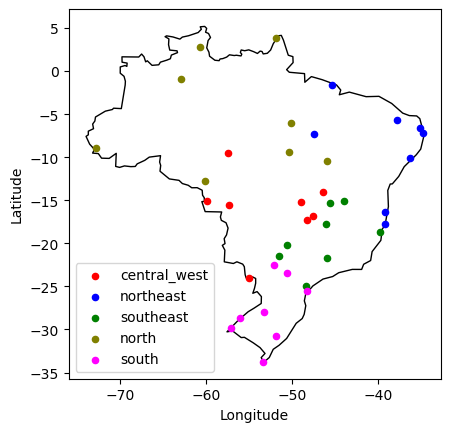

In [7]:
from itertools import cycle

colors = {"central_west": "red", 
          "northeast": "blue", 
          "southeast": "green", 
          "south": "magenta", 
          "north": "olive"}


ax = gdf[gdf["country"]=="Brazil"].plot(color="white", edgecolor="black")

for key, values in data.items(): 
    df = {"name": [], "Latitude": [], "Longitude": []}
    for val in values:
        df["name"].append(key + val.iloc[0].station_code)
        df["Latitude"].append(val.iloc[0].latitude)
        df["Longitude"].append(val.iloc[0].longitude)
    df = pd.DataFrame(df)
    gxdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    gxdf.plot(ax=ax, color=colors[key], label=key, markersize=20)
    ax.legend(loc="lower left") 
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    

In [8]:
from bokeh.plotting import figure, ColumnDataSource, output_notebook
from bokeh.io import show
from bokeh.models import HoverTool

In [9]:
def interactive_weather_stations(data): 
    exterior_coords = {"x": brazil_shape.iloc[0].exterior.xy[0], 
                       "y": brazil_shape.iloc[0].exterior.xy[1]}
    
    exterior_source = ColumnDataSource(exterior_coords)
    p = figure(title="Weather Stations")
    p.line("x", "y", source=exterior_source, color="blue", line_color="blue")
    
    name_source = ColumnDataSource(
        pd.DataFrame(np.array(*[[np.hstack((i.iloc[0][["station_code",
                                            "latitude", 
                                            "longitude"]].to_numpy(), x, colors[x])) 
                                 for x, y in data.items() for i in y]]), 
                      columns=["station_code", "latitude", "longitude", "direction", "color"]))
    
    circles = p.circle("longitude", "latitude", 
                       source=name_source, 
                       radius=0.5, 
                       fill_color="color", 
                       fill_alpha=0.5, line_color="black")
    p.add_tools(HoverTool(tooltips=[("direction", "@direction"), ("station_code", "@station_code")], 
                          renderers=[circles]))

    output_notebook()
    show(p)

interactive_weather_stations(data)

Loading BokehJS ...

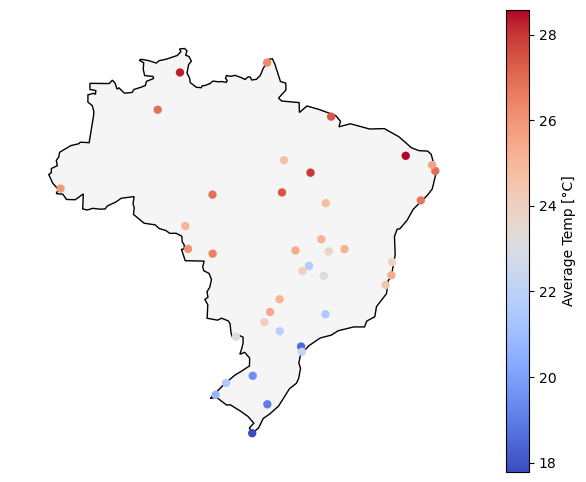

In [49]:
import geoplot as gplt 
import geoplot.crs as gcrs

def location_plot(data: dict, weather_type: str="temperature"): 
    
    geo_plot_data = gpd.GeoDataFrame([(np.nanmean(df["max. temperature in the previous hour (°c)"]),
                                       np.nanmean(df["total precipitation (mm)"]), 
                                       Point(df.iloc[0].longitude,
                                             df.iloc[0].latitude)) for key, value in data.items() for df in value], 
                    columns=["average temp", "average precipation", "geometry"])
    if weather_type == "temperature": 
        ax = gplt.pointplot(geo_plot_data, hue="average temp", legend=True, cmap="coolwarm", 
                            legend_kwargs={"label": "Average Temp [°C]"})

        gplt.polyplot(brazil_shape, facecolor="whitesmoke", ax=ax)
    elif weather_type == "precipation": 
        ax = gplt.pointplot(geo_plot_data, hue="average precipation", legend=True, 
                            legend_kwargs={"label": "Average Precipation [mm]"})

        gplt.polyplot(brazil_shape, facecolor="whitesmoke", ax=ax)

    

location_plot(data)

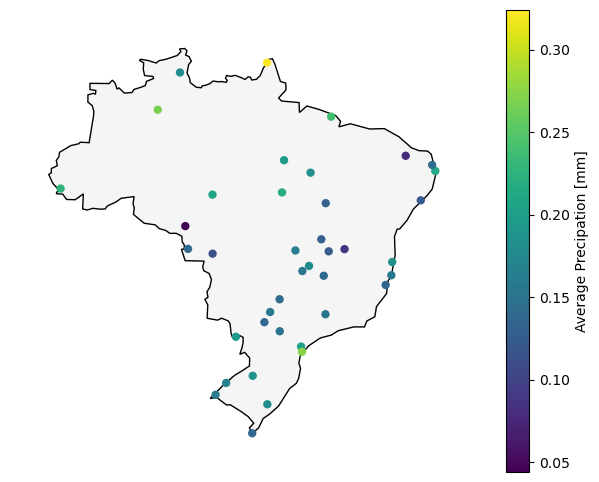

In [50]:
location_plot(data, "precipation")

In [11]:
data["central_west"][0]

,total precipitation (mm),max. temperature in the previous hour (°c),station_code,latitude,longitude
timestamp,,,,,
2007-04-18 00:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 01:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 02:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 03:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 04:00:00,NaN,NaN,A017,-14.089167,-46.366389
...,...,...,...,...,...
2021-04-30 19:00:00,0.0,27.5,A017,-14.089167,-46.366389
2021-04-30 20:00:00,0.0,27.1,A017,-14.089167,-46.366389
2021-04-30 21:00:00,0.0,25.8,A017,-14.089167,-46.366389


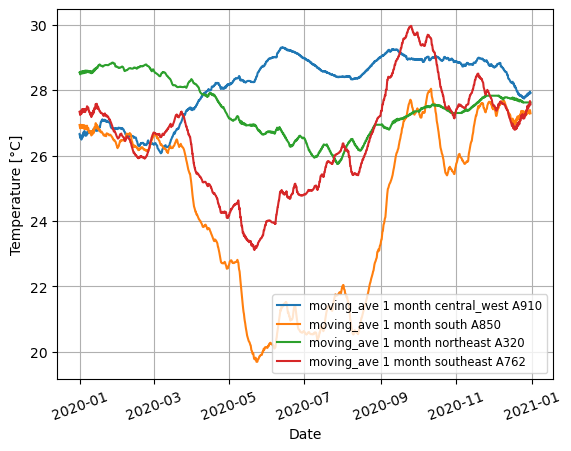

In [23]:
from scipy.ndimage import uniform_filter1d

def plot_temp(data, *keys, start_date, end_date, **kwargs): 
    fig, ax = plt.subplots()
    for key, index in keys:
        plot_data = data[key][index]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date),
                             "max. temperature in the previous hour (°c)"] 
        plot_data.fillna(np.nanmedian(plot_data.to_numpy()), inplace=True)
        if kwargs.get("raw"):
            plt.plot(plot_data, lw=0.1, 
                     label="raw temp data {key} {code}".format(key=key, 
                                                               code=data[key][index].iloc[0]["station_code"]))
        if kwargs.get("moving_mean"):
            filter_period, period_type = kwargs.get("mov_mean_period")
            if period_type == "month": 
                filter_period *= 30 * 24 
            elif period_type == "day": 
                filter_period *= 24
            plt.plot(plot_data.index, uniform_filter1d(plot_data.to_numpy(), 
                                                       filter_period), 
                     label="moving_ave {0} {1} {key} {code}".format(*kwargs.get("mov_mean_period"), 
                                                                   key=key, 
                                                                   code=data[key][index].iloc[0]["station_code"]))
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlabel("Date")
    if kwargs.get("grid"):
        ax.grid()
    plt.xticks(rotation=20)
    plt.legend(fontsize="small")


plot_temp(data, 
          ("central_west", 1), 
          ("south", 0),
          ("northeast", 1), 
          ("southeast", 2),
          start_date=(2020, 1, 1), 
          end_date=(2020, 12, 31), 
          moving_mean=True, 
          mov_mean_period=(1, "month"), 
          grid=True)

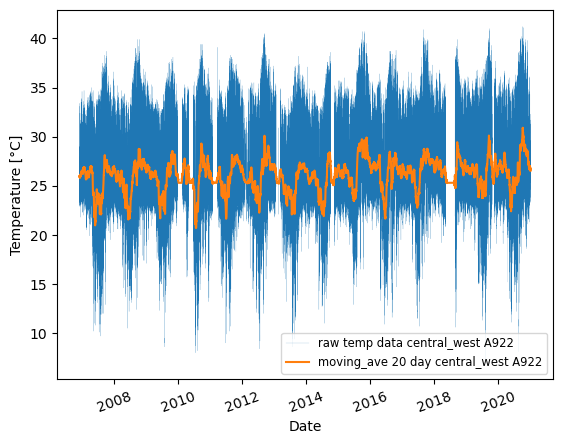

In [27]:
plot_temp(data, 
          ("central_west", 2), 
          start_date=(2006, 1, 1), 
          end_date=(2021, 1, 1), 
          moving_mean=True, 
          raw=True,
          mov_mean_period=(20, "day"))

In [14]:
from itertools import cycle 

color = cycle(["bisque", "peru", "green", "lightblue", "plum"])

def boxplots(data, *keys, start_date, end_date, seperator="Q", apart=0.25, **kwargs):
    """
    Makes a boxplot out of given data, start and end date can be defined as can be seperator which specifies 
    how data is seperated 
    
    # todo: If data is not present in one weather station, make sure plots are still on right quartil, month etc. 
    """
    w_stations = {}
    station_code = []
    for key, index in keys: 
        plot_data = data[key][index]
        station_code.append(plot_data.iloc[0]["station_code"])
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                          "max. temperature in the previous hour (°c)"] 
        plot_data = plot_data.groupby(pd.Grouper(freq=seperator))
        d_single = {}
        for period in plot_data.groups.keys(): 
            x = plot_data.get_group(period).to_numpy()
            x[np.argwhere(np.isnan(x))] = np.nanmedian(x)
            d_single[period] = x
            
        w_stations[key + str(index)] = d_single
    fig, ax = plt.subplots()
    elements = []
    for shift, (key, index) in zip(np.linspace(-apart, 
                                               apart, 
                                               len(keys)) if len(keys) > 1 else [0], keys):
        elements.append(ax.boxplot(w_stations[key + str(index)].values(), 0, "", 
                                   positions=[shift + l for l in range(len(w_stations[key + str(index)]))], 
                                   patch_artist=True, 
                                   boxprops={"facecolor":next(color)}, 
                                   medianprops={"color": "black"}, 
                                   **kwargs
                                  ))
        
        plt.xticks(range(len(w_stations[key + str(index)])), 
                   [seperator + str(j) for j in range(len(w_stations[key + str(index)]))], 
                   rotation=20) 
    ax.set_ylabel("Temperature [°C]")
    ax.legend([element["boxes"][0] for element in elements], 
              [key[:-1] + " " + code for key, code in zip(w_stations.keys(), station_code)])

    

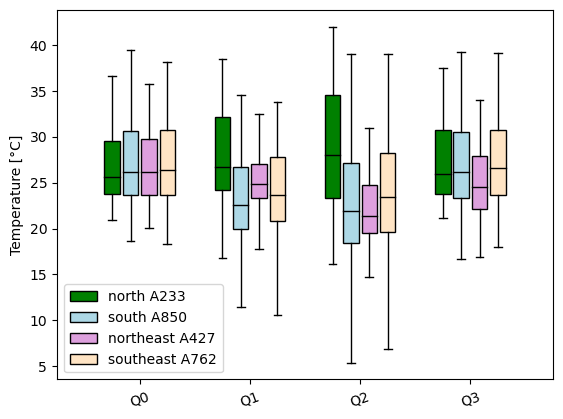

In [28]:
boxplots(data, 
         ("north", 1),  
         ("south", 0),
         ("northeast", 0),
         ("southeast", 2),
         start_date=(2019, 1, 1), 
         end_date=(2019, 12, 31), 
         seperator="Q", 
         widths=0.14)

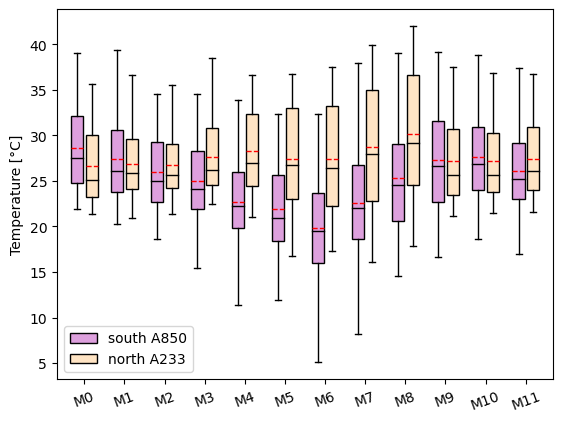

In [33]:
boxplots(data, 
         ("south", 0), 
         ("north", 1),
         start_date=(2019, 1, 1), 
         end_date=(2019, 12, 31), 
         apart=0.18,
         seperator="M", 
         meanline=True, 
         showmeans=True,
         meanprops={"color": "red", "linestyle": "--"}, 
         widths=0.3)

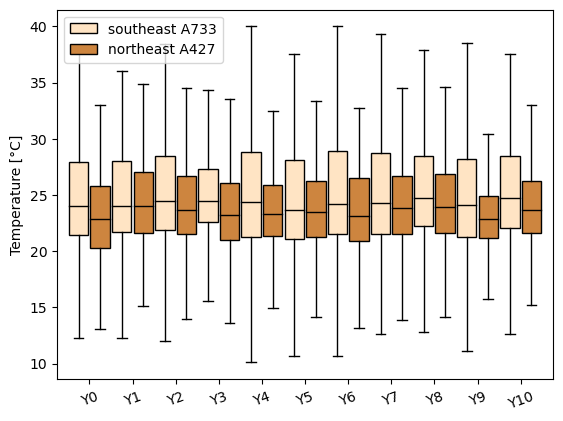

In [31]:
boxplots(data, 
         ("southeast", 3),
         ("northeast", 0),
         start_date=(2008, 1, 1), 
         end_date=(2018, 12, 31), 
         seperator="Y",
         widths=0.45
        )

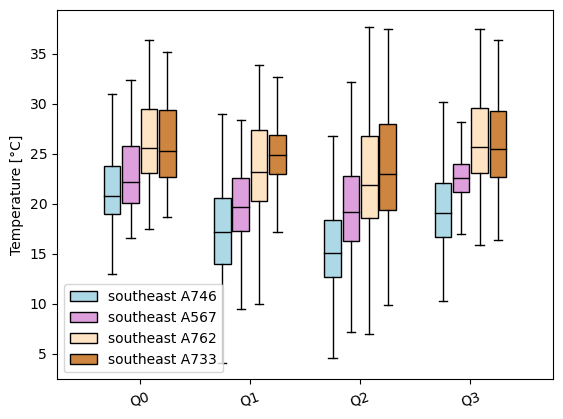

In [18]:
boxplots(data, 
         ("southeast", 0),
         ("southeast", 1), 
         ("southeast", 2), 
         ("southeast", 3),
         start_date=(2018, 1, 1),
         end_date=(2018, 12, 31),
         seperator="Q", widths=0.15)

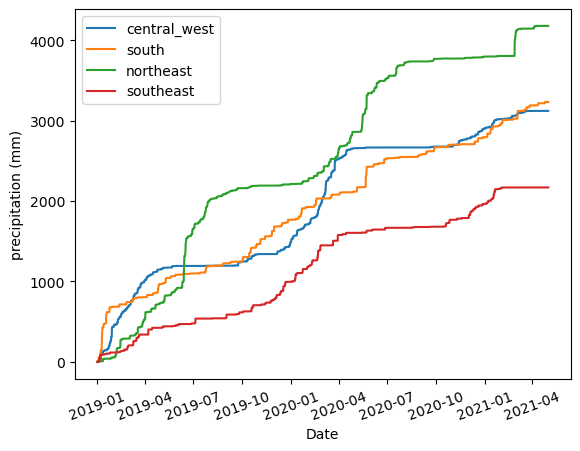

In [19]:
def cumulative_percipitation_plot(data, *keys, start_date, end_date):
    fig, ax = plt.subplots()
    for key, index in keys: 
        plot_data = data[key][index]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                              ["total precipitation (mm)"]]
        plot_data.fillna(plot_data["total precipitation (mm)"].median(), inplace=True)
        plot_data["cumulative"] = np.cumsum(plot_data["total precipitation (mm)"])
        ax.plot(plot_data.index, plot_data["cumulative"].to_numpy(), label=key)
    ax.set_xlabel("Date")
    ax.set_ylabel("precipitation (mm)")
    plt.xticks(rotation=20)
    plt.legend()
    
    

cumulative_percipitation_plot(data, 
                              ("central_west", 1), 
                              ("south", 1),
                              ("northeast", 1),
                              ("southeast", 2), 
                              start_date=(2019, 1, 1), 
                              end_date=(2021, 12, 31))
    
    